# Выбор локации для скважины

Компании **«ГлавРосГосНефть»** нужно решить, где бурить новую скважину.

Были предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 
**Цель:** построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Задача:** необходимо создать модель, которая будет отбирать 200 лучших точек по объему сырья и рассчитывать суммарную прибыль для региона. Далее необходимо на основе полученных данных и риске убытка предоставить рекомендации по тому, где следует бурить новую скважину.

**Этапы проекта:**
1. Загрузка и подготовка данных.
2. Обучение и проверка модели для каждого региона.
3. Подготовка к расчету прибыли.
4. Расчет предсказанной прибыли по каждому региону.
5. Расчет рисков, средней прибыли и доверительного интервала.
6. Выводы.

## Загрузка и подготовка данных

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

from sklearn.metrics import mean_squared_error
import numpy as np

### Загрузка и просмотр данных ###

In [2]:
# Загрузка данных и вывод первых строк
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
display(df_0.head())
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
display(df_1.head())
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Подготовка данных ###

In [3]:
# Проверка данных на наличие пропусков
print(f'Количество пропусков в данных df_0: {df_0.isna().sum()}')
print(f'Количество пропусков в данных df_1: {df_1.isna().sum()}')
print(f'Количество пропусков в данных df_2: {df_2.isna().sum()}')

Количество пропусков в данных df_0: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество пропусков в данных df_1: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество пропусков в данных df_2: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [4]:
# Проверка на наличие явных дубликатов
print(f'Количество явных дубликатов в данных df_0: {df_0.duplicated().sum()}')
print(f'Количество явных дубликатов в данных df_1: {df_1.duplicated().sum()}')
print(f'Количество явных дубликатов в данных df_2: {df_2.duplicated().sum()}')

Количество явных дубликатов в данных df_0: 0
Количество явных дубликатов в данных df_1: 0
Количество явных дубликатов в данных df_2: 0


In [5]:
# Проверка типов данных
print(df_0.info())
print(df_1.info())
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
                  f0             f1             f2        product
count  100000.000000  10

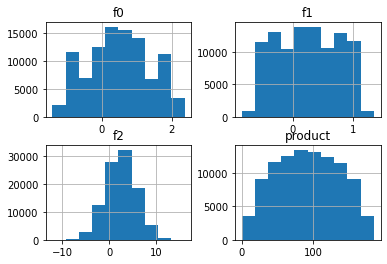

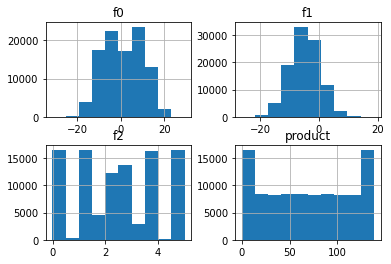

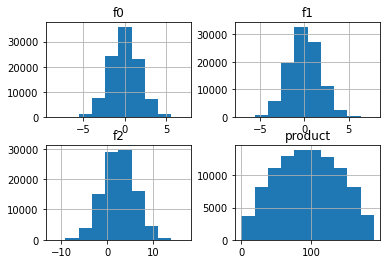

In [6]:
# Проверка данных на наличие ошибок и аномалий
print(df_0.hist())
print(df_0.describe())
print(df_1.hist())
print(df_1.describe())
print(df_2.hist())
print(df_2.describe())

AxesSubplot(0.125,0.125;0.62x0.755)


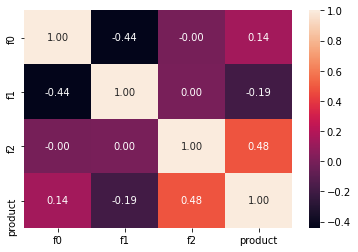

In [7]:
# Матрица корреляции
print(sns.heatmap(df_0.corr(), annot=True, fmt='.2f'))

AxesSubplot(0.125,0.125;0.62x0.755)


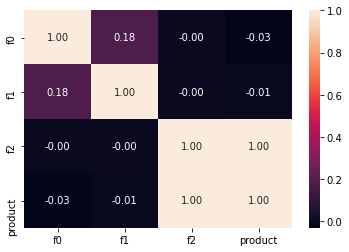

In [8]:
print(sns.heatmap(df_1.corr(), annot=True, fmt='.2f'))

AxesSubplot(0.125,0.125;0.62x0.755)


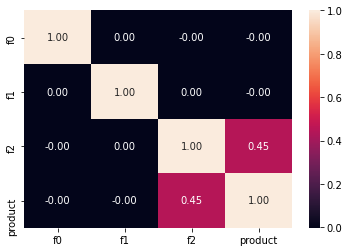

In [9]:
print(sns.heatmap(df_2.corr(), annot=True, fmt='.2f'))

**Выводы**

На первом этапе была осуществлена загрузка данных, а также проведена проверка на наличие пропусков, дубликатов, корректности типов данных, ошибок и аномалий. В результате анализа было установлено, что данные являются корректными, а распределения признаков в df_0 и df_2 соответствуют нормальному распределению. Однако, в df_1 признаки f2 и product не демонстрируют нормального распределения.

Дополнительно была выявлена умеренная корреляционная связь между признаками f2 и product в наборах данных df_0 и df_2, а также сильная корреляция между этими признаками в df_1.

## Обучение и проверка модели

Для обучения модели подходит только **линейная регрессия** (остальные — недостаточно предсказуемые).

In [10]:
#  2.1. Разделение данных на обучающую и валидационную выборки в соотношении 75:25.
X0 = df_0.drop(['id', 'product'], axis = 1)
y0 = df_0['product']
X1 = df_1.drop(['id', 'product'], axis = 1)
y1 = df_1['product']
X2 = df_2.drop(['id', 'product'], axis = 1)
y2 = df_2['product']

X_train_0, X_valid_0,  y_train_0, y_valid_0 = train_test_split(X0, y0, test_size = 0.25, random_state = RANDOM_STATE)
X_train_1, X_valid_1,  y_train_1, y_valid_1 = train_test_split(X1, y1, test_size = 0.25, random_state = RANDOM_STATE)
X_train_2, X_valid_2,  y_train_2, y_valid_2 = train_test_split(X2, y2, test_size = 0.25, random_state = RANDOM_STATE)

scaler = StandardScaler()

X_train_0_scaler = scaler.fit_transform(X_train_0)
X_valid_0_scaler = scaler.transform(X_valid_0)

X_train_1_scaler = scaler.fit_transform(X_train_1)
X_valid_1_scaler = scaler.transform(X_valid_1)

X_train_2_scaler = scaler.fit_transform(X_train_2)
X_valid_2_scaler = scaler.transform(X_valid_2)

In [11]:
#  2.2. Обучение модели и прогноз на валидационной выборке.
model_lr_0 = LinearRegression()
model_lr_1 = LinearRegression()
model_lr_2 = LinearRegression()

model_lr_0.fit(X_train_0_scaler, y_train_0)
model_lr_1.fit(X_train_1_scaler, y_train_1)
model_lr_2.fit(X_train_2_scaler, y_train_2)

LinearRegression()

In [12]:
#  2.3. Сохранение предсказаний и правильных ответов на валидационной выборке.
pred_0 = model_lr_0.predict(X_valid_0_scaler)
pred_1 = model_lr_1.predict(X_valid_1_scaler)
pred_2 = model_lr_2.predict(X_valid_2_scaler)

In [13]:
#  2.4.Средний запас предсказанного сырья и RMSE модели.
rmse_0 = mean_squared_error(y_valid_0, pred_0, squared=False)
rmse_1 = mean_squared_error(y_valid_1, pred_1, squared=False)
rmse_2 = mean_squared_error(y_valid_2, pred_2, squared=False)

print(f'Cредний запас предсказанного сырья df_0: {pred_0.mean()}, сс: {rmse_0}')
print(f'Cредний запас предсказанного сырья df_1: {pred_1.mean()}, RMSE: {rmse_1}')
print(f'Cредний запас предсказанного сырья df_2: {pred_2.mean()}, RMSE: {rmse_2}')

Cредний запас предсказанного сырья df_0: 92.39879990657768, сс: 37.75660035026169
Cредний запас предсказанного сырья df_1: 68.7128780391376, RMSE: 0.8902801001028846
Cредний запас предсказанного сырья df_2: 94.77102387765939, RMSE: 40.145872311342174


**Выводы**

На этапе обучения и проверки модели данные были разделены на обучающую и валидационную выборки в соотношении 75:25.  Количественные признаки были масштабированы с помощью StandardScaler. После чего данные были обучены с помощью модели LinearRegression и сделаны предсказания на валидационных выборках.

Регионы df_0 и df_2 имеют лучший средний запас предсказанного сырья. При этом, регион df_1 имеет наименьшую среднеквадратичную ошибку, что свидетельствует о наибольшей точности прогнозирования запасов сырья для данного региона.

## Подготовка к расчёту прибыли

Условия задачи:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [14]:
# 3.1. Ключевые значения для расчётов
n = 500
best_n = 200
budget = 10000000000
price = 450000
prob_losses = 0.025
pred_0_avg = pred_0.mean()
pred_1_avg = pred_1.mean()
pred_2_avg = pred_2.mean()

In [15]:
# 3.2. Вычисление достаточного объёма сырья для безубыточной разработки новой скважины
budget_one = budget / best_n
sufficient_volume_of_raw_materials = budget_one / price

# Сравнение полученного объём сырья со средним запасом в каждом регионе
if sufficient_volume_of_raw_materials > pred_0_avg:
    print('Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_0')
else:
    print('Средний предсказанный уровень добываемого сырье, больше или равно необходимому в регионе df_0')

if sufficient_volume_of_raw_materials > pred_1_avg:
    print('Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_1')
else:
    print('Средний предсказанный уровень добываемого сырье, больше или равно необходимому в регионе df_1')

if sufficient_volume_of_raw_materials > pred_2_avg:
    print('Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_2')
else:
    print('Средний предсказанный уровень добываемого сырье, больше или равно необходимому в регионе df_2')

Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_0
Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_1
Средний предсказанный уровень добываемого сырье, меньше необходимого в регионе df_2


**Выводы**

Во всех трех регионах средний объем предсказываемого добываемого сырья меньше, чем необходимо для безубыточного производства. Следовательно, в 200 лучших точках должны быть скважины с прогнозным значением добываемого сырья более чем 111 баррель.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели: ##

In [16]:
# 4.1. Выбор скважины с максимальными значениями предсказаний
def profit(target, pred, count=200, price=450000):
    # лучшие 200 скважин по объему предсказания сырья
    best = pred.argsort()[-count:]
    selected_targets = target.iloc[best]
    # Суммарная прибыль по всем точкам в регионе
    total_profit = selected_targets.sum() * price
    return total_profit

In [17]:
# 4.3. Расчет прибыли для полученного объёма сырья
profit_0 = profit(y_valid_0, pred_0)
profit_1 = profit(y_valid_1, pred_1)
profit_2 = profit(y_valid_2, pred_2)

print(f'Прибыль по региону df_0: {profit_0:,.0f} руб.')
print(f'Прибыль по региону df_1: {profit_1:,.0f} руб.')
print(f'Прибыль по региону df_2: {profit_2:,.0f} руб.')


Прибыль по региону df_0: 13,359,141,114 руб.
Прибыль по региону df_1: 12,415,086,697 руб.
Прибыль по региону df_2: 12,598,571,759 руб.


## Расчёт прибыли и рисков для каждого региона:

In [18]:
# 5.1. Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли
def profit(data, y_true, pred):
    data = data.copy()
    # Добавляем предсказанные и фактические значения целевого признака "объем сырья"
    data['predict'] = pred
    data['true'] = y_true
    # Сортируем по предсказанному объему и отбираем 200 лучших точек
    selected = data.sort_values(by='predict', ascending=False).head(200)
    # Рассчитываем прибыль и вычитаем необходимые расходы
    revenue = selected['true'].sum() * 450000
    return revenue - budget

prib_0 = [] # Список для прибыли

for i in range(1000): # Bootstrap
    # Берем случайную выборку из 500 значений с возвращением 
    subsample = X_valid_0.sample(n=500, replace=True, random_state=12345 + i)
    # По индексам подвыборки извлекаем фактические и предсказанные значения
    true_sub = y_valid_0.loc[subsample.index]
    pred_sub = pd.Series(pred_0, index=X_valid_0.index).loc[subsample.index]
    profit_val = profit(subsample, true_sub, pred_sub)
    prib_0.append(profit_val)

prib_0 = pd.Series(prib_0)

# 5.2. Средняя прибыль, 95%-й доверительный интервал и риск убытков.
mean_profit = prib_0.mean()
lower = prib_0.quantile(0.025)
upper = prib_0.quantile(0.975)
risk = (prib_0 < 0).mean()

print(f'Средняя прибыль df_0: {mean_profit:,.0f} руб.')
print(f'95%-доверительный интервал: от {lower:,.0f} до {upper:,.0f} руб.')
print(f'Риск убытков: {risk*100:.2f}%')

Средняя прибыль df_0: 410,864,862 руб.
95%-доверительный интервал: от -114,492,946 до 922,590,264 руб.
Риск убытков: 5.90%


In [19]:
#  Регион df_1
prib_1 = []

for i in range(1000):
    subsample = X_valid_1.sample(n=500, replace=True, random_state=12345 + i)
    true_sub = y_valid_1.loc[subsample.index]
    pred_sub = pd.Series(pred_1, index=X_valid_1.index).loc[subsample.index]
    profit_val = profit(subsample, true_sub, pred_sub)
    prib_1.append(profit_val)

prib_1 = pd.Series(prib_1)

mean_profit = prib_1.mean()
lower = prib_1.quantile(0.025)
upper = prib_1.quantile(0.975)
risk = (prib_1 < 0).mean()

print(f'Средняя прибыль df_1: {mean_profit:,.0f} руб.')
print(f'95%-доверительный интервал: от {lower:,.0f} до {upper:,.0f} руб.')
print(f'Риск убытков: {risk*100:.2f}%')

Средняя прибыль df_1: 444,696,497 руб.
95%-доверительный интервал: от 57,400,466 до 843,688,772 руб.
Риск убытков: 1.60%


In [20]:
# Регион df_2
prib_2 = []

for i in range(1000):
    subsample = X_valid_2.sample(n=500, replace=True, random_state=12345 + i)
    true_sub = y_valid_2.loc[subsample.index]
    pred_sub = pd.Series(pred_2, index=X_valid_2.index).loc[subsample.index]
    profit_val = profit(subsample, true_sub, pred_sub)
    prib_2.append(profit_val)

prib_2 = pd.Series(prib_2)

mean_profit = prib_2.mean()
lower = prib_2.quantile(0.025)
upper = prib_2.quantile(0.975)
risk = (prib_2 < 0).mean()

print(f'Средняя прибыль df_2: {mean_profit:,.0f} руб.')
print(f'95%-доверительный интервал: от {lower:,.0f} до {upper:,.0f} руб.')
print(f'Риск убытков: {risk*100:.2f}%')

Средняя прибыль df_2: 392,870,293 руб.
95%-доверительный интервал: от -161,358,170 до 907,462,242 руб.
Риск убытков: 7.10%


**Выводы**

На основании проведенного анализа и прогнозирования совокупной прибыли по регионам, были сделаны следующие выводы:

* В регионе df_0 прогнозируемый объем прибыли по 200 наиболее эффективным точкам составляет 13,3 миллиарда рублей, что превышает минимально необходимый уровень для покрытия затрат в размере 10 миллиардов рублей.
* В регионе df_1 прогнозируемый объем прибыли по 200 наиболее эффективным точкам составляет 12,4 миллиарда рублей, что также превышает минимально необходимый уровень для покрытия затрат.
* В регионе df_2 прогнозируемый объем прибыли по 200 наиболее эффективным точкам составляет 12,6 миллиарда рублей, что соответствует минимально необходимому уровню для покрытия затрат.

Дополнительно были произведены расчеты средней прибыли, доверительного интервала и вероятности убытков с использованием метода Bootstrap.

Таким образом, регион df_1 демонстрирует наилучшие показатели в контексте минимизации рисков убытков. Средняя прибыль по данному региону составляет 444,7 миллиона рублей, при этом доверительный интервал варьируется от 57,4 миллиона до 843,7 миллиона рублей. Вероятность убытков составляет 1,60%.

Регион df_1 является наиболее предпочтительным для разработки месторождений, поскольку, помимо низкого уровня риска убытков, с вероятностью 95% будет обеспечивать положительный финансовый результат. В отличие от регионов df_0 и df_2, где существует вероятность убытков.


## Итоговый вывод ##

Были предоставлены данные о трех регионах, признаки и целевой показатель — объем сырья в точке. 

**Задача:** разработать модель, которая отбирает 200 точек с наибольшим объемом сырья для каждого региона и рассчитывает суммарную прибыль. На основе полученных данных и оценки риска убытка предоставить рекомендации относительно оптимального места для бурения новой скважины.

Для достижения поставленной цели были выполнены следующие этапы:

Осуществлена загрузка данных, проведена проверка на наличие пропусков, дубликатов, корректность типов данных, ошибок и аномалий. Данные признаны корректными, а распределения df_0 и df_2 соответствуют нормальному распределению. Признаки f2 и product в наборе данных df_1 не имеют нормального распределения.
Выявлена умеренная корреляция между признаками f2 и product в наборах данных df_0 и df_2, а также сильная корреляция между этими признаками в наборе данных df_1.

Регионы df_0 и df_2 обладают лучшим средним запасом предсказанного сырья. В то же время, регион df_1 демонстрирует наименьшую среднеквадратичную ошибку, что свидетельствует о наиболее точной прогнозной модели для данного региона.

Затем был проведен расчет среднего объема прогнозируемого добываемого сырья, который оказался меньше требуемого для безубыточного производства в каждом из трех регионов.

На 4 этапе были рассчитаны предсказания суммарной прибыли по регионам:
- в регионе df_0 суммарная прибыль составляет 13,3 млрд рублей;
- в регионе df_1 суммарная прибыль составляет 12,4 млрд рублей;
- в регионе df_2 суммарная прибыль составляет 12,6 млрд рублей.
  
Лучший регион, который соответствует условию риск убытков меньше 2,5%, — df_1. Со средней прибылью 444,7 млн, доверительным интервалом от 57,4 млн до 843,7 млн руб. и риском убытков: 1,60%. Данный регион является лучшим для разработки месторождений, т.к. помимо низкого риска убытков, с 95% вероятностью будет иметь положительную прибыль.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован